<h1>Clothing Attribute Prediction</h1>
<strong>Sources</strong>:
<ul>
    <li>Tania Tatiana Sennikova - <a>https://github.com/tsennikova/fashion-ai/</a></li>
    <li>FastAI Tutorial - <a>https://docs.fast.ai/tutorial.vision.html</a></li>
</ul>

<h2>Importing Data</h2>
<ul>
    <li>DeepFashion Category and Attribute Prediction Benchmark - <a>https://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/AttributePrediction.html</a>
        <p>This dataset contains a directory of 289,222 images of clothes pictured by themselves and being worn by models. It also contains txt files that describe the set (test, train, validation) and labeled attributes of each image, however, we used pre-processed CSV files provided by Tania Tatiana Sennikova for simplicity. These reduce the attribute classes from 1000 classes to 98 classes which is helpful because many of the thousand classes are redundant. The CSV files also come pre-sorted by training, test, and validation sets as well as contain the written attributes for each images, rather than thousand-column long one-hot encodings for every image.</p>
    </li>
</ul>

In [1]:
from fastai.vision.all import *

PATH = "deepfashion/"

In [3]:
# Process training CSV
train_df = pd.read_csv("fashion_ai/multilabel-train.csv")
train_df.head()

,image_name,labels,is_valid
0,img\Sheer_Pleated-Front_Blouse\img_00000002.jpg,"pleated,sheer",0.0
1,img\Sheer_Pleated-Front_Blouse\img_00000003.jpg,"chic,pleated",1.0
2,img\Sheer_Pleated-Front_Blouse\img_00000006.jpg,pleated,1.0
3,img\Sheer_Pleated-Front_Blouse\img_00000009.jpg,"sheer,sophisticated",0.0
4,img\Sheer_Pleated-Front_Blouse\img_00000010.jpg,"relaxed,sheer,woven",0.0


In [4]:
# Source: https://github.com/tsennikova/fashion-ai/
def get_x(r): return PATH+r['image_name']
def get_y(r): return r['labels'].split(',')
def splitter(df):
    train = df.index[df['is_valid']==0].tolist()
    valid = df.index[df['is_valid']==1].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=RandomResizedCrop(224, min_scale=0.8),
                   batch_tfms=aug_transforms())

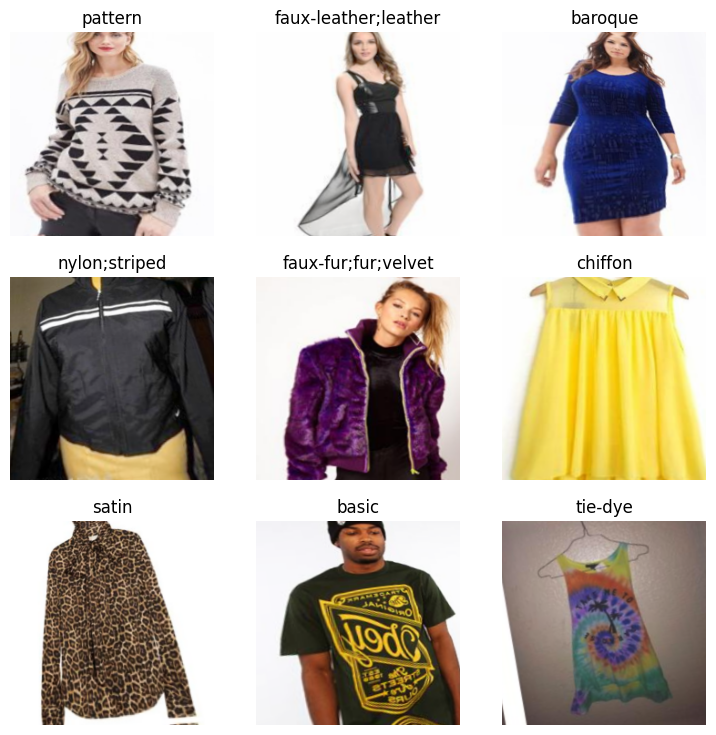

In [5]:
dls = dblock.dataloaders(train_df)

# View images with labels
dls.show_batch(max_n=9)

<h2>Training Model</h2>
<p>Using Label Smoothing slightly reduces the confidence of the model in the given training set labels. This eases overfitting as the labels for some images seem subjectively defined. This is likely a result of the dataset being quite large.</p>

In [6]:
# Source: https://github.com/tsennikova/fashion-ai/
class LabelSmoothingBCEWithLogitsLossFlat(BCEWithLogitsLossFlat):
    def __init__(self, eps:float=0.1, **kwargs):
        self.eps = eps
        super().__init__(thresh=0.2, **kwargs)

    def __call__(self, inp, targ, **kwargs):
        # https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/166833#929222
        targ_smooth = targ.float() * (1. - self.eps) + 0.5 * self.eps
        return super().__call__(inp, targ_smooth, **kwargs)

    def __repr__(self):
        return "FlattenedLoss of LabelSmoothingBCEWithLogits()"
    
metrics=[FBetaMulti(2.0, 0.2, average='samples'), partial(accuracy_multi, thresh=0.2)]

In [46]:
learn = vision_learner(dls, resnet34, loss_func=LabelSmoothingBCEWithLogitsLossFlat(),
            metrics=metrics)

SuggestedLRs(valley=0.002511886414140463)

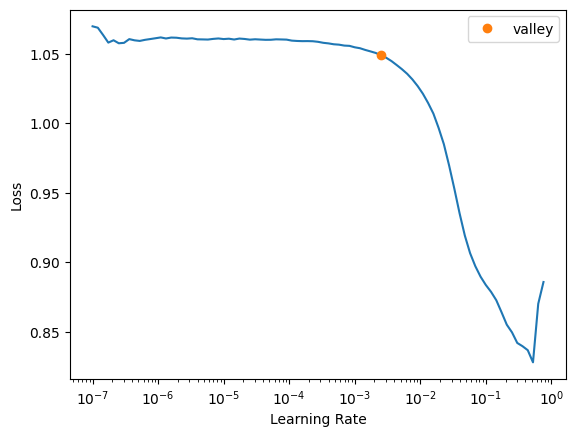

In [47]:
learn.lr_find()

In [48]:
learn.fine_tune(2, 2e-3) #Using suggested valley learning rate
learn.save('attribute-prediction-resnet34-v2')

epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.231526,0.228042,0.353287,0.982037,25:47


epoch,train_loss,valid_loss,fbeta_score,accuracy_multi,time
0,0.227295,0.225440,0.415823,0.983141,28:49
1,0.225962,0.224565,0.433095,0.983715,28:48


Path('models/attribute-prediction-resnet34-v2.pth')

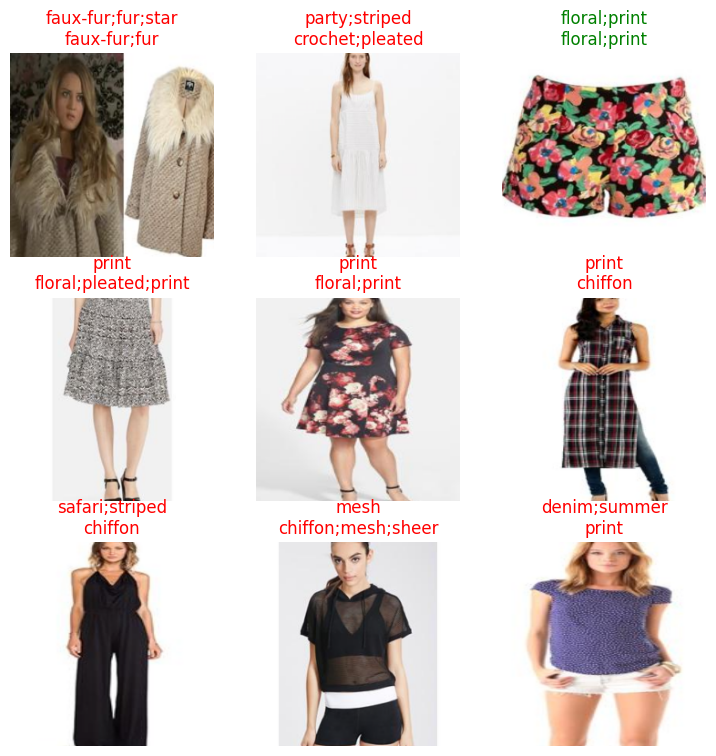

In [50]:
learn.show_results()

<h2>Performance on Test Data</h2>

In [51]:
test_df = pd.read_csv("fashion_ai/multilabel-test.csv")
test_df.head()

,image_name,labels
0,img\Sheer_Pleated-Front_Blouse\img_00000005.jpg,"feather,pleated"
1,img\Sheer_Pleated-Front_Blouse\img_00000007.jpg,"pleated,sheer"
2,img\Sheer_Pleated-Front_Blouse\img_00000013.jpg,sheer
3,img\Sheer_Pleated-Front_Blouse\img_00000019.jpg,pleated
4,img\Sheer_Pleated-Front_Blouse\img_00000020.jpg,sheer


In [52]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=get_x,
                   get_y=get_y,
                   item_tfms=Resize(224))

test_dls = dblock.dataloaders(test_df)

In [53]:
learn.data = test_dls
learn.validate()

(#3) [0.2245650291442871,0.43309546725225495,0.9837146997451782]

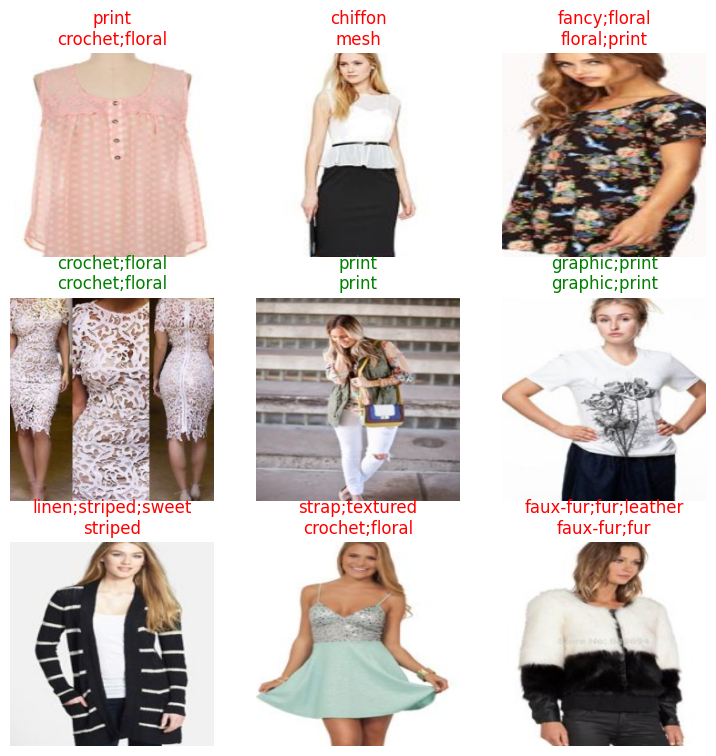

In [55]:
learn.show_results()

<h2>Performance on New Images</h2>

['floral', 'print']


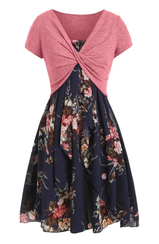

In [61]:
image_path = 'FLORAL+DRESS-1351218936.jpg' # source: https://thisisalittlepieceofme.blogspot.com/2020/05/dresslily-spring-2020-wishlist.html
print(learn.predict(image_path)[0])

img=Image.open(image_path)
img.thumbnail((244,244),Image.LANCZOS)
display(img)